In [2]:
# Importing required libraries
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import random

### IMPLEMENTATION OF GEM HUNT ENVIRONMENT

In [3]:
from matplotlib.colors import ListedColormap
from gym import spaces

class GemHuntEnv():

  def __init__(self):
    # Initializes the class, action and observation space

    # Defining the grid size which is a 3*4 matrix
    self.grid_size = 3, 4

    self.observation_space = spaces.Discrete(np.prod(self.grid_size))
    self.action_space = spaces.Discrete(4)

    # Defining the positions for the agent, treasure and hazard
    self.current_pos = 0
    self.gem_pos = 3
    self.rock_pos = 6
    
    # Defining the rewards
    self.reward_dictionary = {}
    self.reward_dictionary[self.gem_pos] = 10
    self.reward_dictionary[self.rock_pos] = -10
    self.reward_range = (-10, 10)

    # Calling reset method to get back to the initial position
    self.reset()

  def reset(self):
    # Resets the state of the environment to an initial position

    self.current_pos = 0
    self.agent_pos = 0
    self.state = self.agent_pos

    return self.state

  def move_agent(self, action):

    # Actions dictionary contains 4 values where 0,1,2,3 are keys, and actions are values
    actions = {
      0: self.move_up,
      1: self.move_down,
      2: self.move_right,
      3: self.move_left,
    }

    if action in actions:
      actions[action]()
    else:
      print("Invalid action:", action)

  # Defining methods to move the agents according to action
  def move_up(self):
    if self.grid_size[1] <= self.agent_pos:
      self.agent_pos = self.agent_pos - self.grid_size[1]

  def move_down(self):
    if self.grid_size[0] * self.grid_size[1] - self.grid_size[1] > self.agent_pos:
      self.agent_pos = self.agent_pos + self.grid_size[1]

  def move_right(self):
    if (self.agent_pos + 1) % self.grid_size[1] != 0:
      self.agent_pos = self.agent_pos + 1

  def move_left(self):
    if self.agent_pos % self.grid_size[1] != 0:
      self.agent_pos = self.agent_pos - 1

  def step(self, action):
    # Input is the action

    # Define the actions using move_agent() method
    self.move_agent(action)
    self.current_pos += 1
    done = False
    self.state = self.agent_pos

    # Setting the reward based on the reward_dictionary values
    reward = 0
    if self.state in self.reward_dictionary:
      reward = reward + self.reward_dictionary[self.state]
      done = True
    else:
      reward = reward - 0.1

    return self.state, reward, done

  def render(self):
    # Visualizes the environment
  
    # Create a colormap for the grid cells
    cmap = ListedColormap(['darkblue', 'yellow', 'magenta', 'red'])
    
    # Create an empty grid with the correct size
    grid = np.zeros(self.grid_size)
    
    # Place the agent row position
    agent_row, agent_col = divmod(self.agent_pos, self.grid_size[1])
    grid[agent_row, agent_col] = 1
    
    # Place the goal row position
    goal_row, goal_col = divmod(self.gem_pos, self.grid_size[1])
    grid[goal_row, goal_col] = 2
    
    # Place the rock row position
    rock_row, rock_col = divmod(self.rock_pos, self.grid_size[1])
    grid[rock_row, rock_col] = 3
    
    # Show the grid using a color map
    plt.figure(figsize = (6, 8))
    plt.imshow(grid, cmap = cmap, interpolation ='nearest')
    plt.axis('off')
    plt.show()

### SARSA ALGORITHM

In [4]:
import seaborn as sns

class SARSA:
  
    def __init__(self, env, num_episodes, max_timesteps, alpha, gamma, epsilon, epsilon_decay, epsilon_min):
      #Initializing the SARSA agent with the environment and hyperparameters.
      #creating a Q-table to store the action-values for each state-action pair in the environment.
        self.env = env
        self.num_episodes = num_episodes
        self.max_timesteps = max_timesteps
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.Q = {}
        #Initializing Q-values for each state-action pair to 0
        for state in range(env.observation_space.n):
            self.Q[state] = {}
            for action in range(env.action_space.n):
                self.Q[state][action] = 0
        self.rewards = []

    #Choosing an action for the given state either by exploiting the Q-value or by exploring randomly.
    def exploratory_action(self, state):
      if np.random.rand() < self.epsilon:
        #Choosing a random action
          return self.env.action_space.sample()
      else:
        #Choosing the action with the highest Q-value for the current state
          actions = list(self.Q[state].keys())
          values = list(self.Q[state].values())
          max_value = max(values)
          max_indices = [i for i, v in enumerate(values) if v == max_value]
          if len(max_indices) == 0:
            #Choosing a random action if all Q-values are 0
              return self.env.action_space.sample()
          elif len(max_indices) > 1:
            #Choosing one randomly if there are multiple actions with the same highest Q-value
              max_indices = [i for i in max_indices if actions[i] != self.env.action_space.sample()]
              if len(max_indices) == 0:
                #Choosing the one if the chosen action is the only one with the highest Q-value
                  return self.env.action_space.sample()
          return actions[random.choice(max_indices)]

    #Updating the Q-value for the given state-action pair
    def q_update(self, state, action, reward, next_state, next_action):
      q = self.Q.get(state, {})
      next_q = self.Q.get(next_state, {})
      q[action] = q.get(action, 0)
      next_q[next_action] = next_q.get(next_action, 0)
      td_error = reward + self.gamma * next_q[next_action] - q[action]
      q[action] += self.alpha * td_error
      self.Q[state] = q
      self.Q[next_state] = next_q

    #Defining a function to run episodes of the algorithm
    def run_episode(self, episode):
      #resetting the environment
      state = self.env.reset()
      done = False
      reward_total = 0
      t = 0
      #Running the episode until it's done or the maximum number of timesteps is reached
      while not done and t < self.max_timesteps:
          action = self.exploratory_action(state)
          next_state, reward, done = self.env.step(action)
          reward_total += reward
          t += 1
          #Updating Q-values for the current state-action pair
          for next_action in range(self.env.action_space.n):
              self.q_update(state, action, reward, next_state, next_action)
          state = next_state
      #Updating the epsilon and appending the total reward to the list of rewards
      self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
      self.rewards.append(reward_total)
      #Printing the episode number, epsilon value, and cumulative reward obtained in the episode
      print(f"Current episode: {episode + 1}, Epsilon Value: {self.epsilon:.4f}, Cumulative Reward: {reward_total}")

    #Training the agent by running multiple episodes
    def train(self):
      episode = 0
      while episode < self.num_episodes:
          self.run_episode(episode)
          episode += 1

    #Plotting the cumulative rewards obtained in each episode
    def plot_rewards(self):
      sns.set_style('darkgrid')
      sns.set_palette('muted')
      plt.figure(figsize=(8, 4))
      sns.lineplot(x=range(self.num_episodes), y = self.rewards)
      plt.title('Cumulative reward vs. Episode', fontsize=20)
      plt.xlabel('Episode', fontsize=16)
      plt.ylabel('Cumulative reward', fontsize=16)
      plt.tick_params(axis='both', which='major', labelsize=12)
      plt.show()

    #Running the training process and returning the learned Q-values and rewards
    def run(self):
        self.train()
        self.plot_rewards()
        return self.Q, self.rewards


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
env = GemHuntEnv()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### BEST PARAMETERS SARSA AGENT

In [6]:
# Running the agent with the best results obtained from the part-1 SARSA model
gamma = 0.50
epsilon_decay=0.80
episodes = 100
timesteps = 15
alpha = 0.1
epsilon = 1.0
epsilon_min = 0.01
best_sarsa_agent = SARSA(env, episodes, timesteps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

Current episode: 1, Epsilon Value: 0.8000, Cumulative Reward: 9.8
Current episode: 2, Epsilon Value: 0.6400, Cumulative Reward: -10.7
Current episode: 3, Epsilon Value: 0.5120, Cumulative Reward: 9.0
Current episode: 4, Epsilon Value: 0.4096, Cumulative Reward: 9.3
Current episode: 5, Epsilon Value: 0.3277, Cumulative Reward: 9.4
Current episode: 6, Epsilon Value: 0.2621, Cumulative Reward: 9.5
Current episode: 7, Epsilon Value: 0.2097, Cumulative Reward: 9.7
Current episode: 8, Epsilon Value: 0.1678, Cumulative Reward: -10.3
Current episode: 9, Epsilon Value: 0.1342, Cumulative Reward: 9.8
Current episode: 10, Epsilon Value: 0.1074, Cumulative Reward: -10.8
Current episode: 11, Epsilon Value: 0.0859, Cumulative Reward: 9.8
Current episode: 12, Epsilon Value: 0.0687, Cumulative Reward: 9.8
Current episode: 13, Epsilon Value: 0.0550, Cumulative Reward: 9.8
Current episode: 14, Epsilon Value: 0.0440, Cumulative Reward: 9.8
Current episode: 15, Epsilon Value: 0.0352, Cumulative Reward: 9.

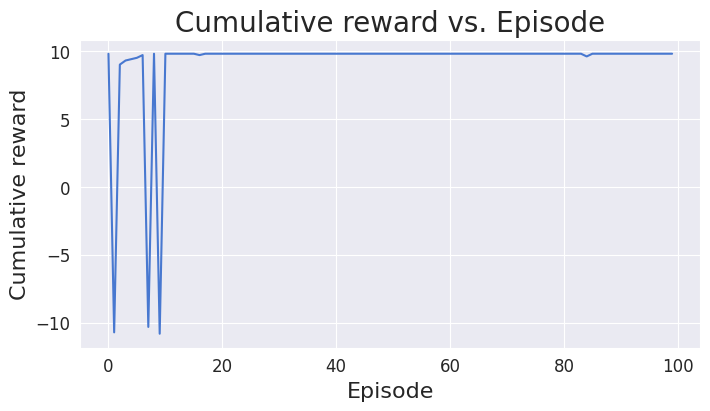

In [7]:
Q_sarsa, rewards_sarsa = best_sarsa_agent.run()

### 2-STEP BOOTSTRAPPING SARSA

In [8]:
class TWO_STEP_SARSA:
  
  def __init__(self, env, num_episodes, max_timesteps, alpha, gamma, epsilon, epsilon_decay, epsilon_min):

    # Initializing the SARSA agent with the environment and hyperparameters.

    self.env = env
    self.num_episodes = num_episodes
    self.max_timesteps = max_timesteps
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon
    self.epsilon_decay = epsilon_decay
    self.epsilon_min = epsilon_min
    self.Q = {}
    self.n = 2

    # Initializing Q-values for each state-action pair to 0
    for state in range(env.observation_space.n):
        self.Q[state] = {}
        for action in range(env.action_space.n):
            self.Q[state][action] = 0
    self.rewards = []

  # Choosing an action for the given state either by exploiting the Q-value or by exploring randomly.
  def exploratory_action(self, state):
    if np.random.rand() < self.epsilon:
        # Choosing a random action
        return self.env.action_space.sample()
    else:
        # Choosing the action with the highest Q-value for the current state
        actions = list(self.Q[state].keys())
        values = list(self.Q[state].values())
        max_value = max(values)
        max_indices = [i for i, v in enumerate(values) if v == max_value]
        if len(max_indices) == 0:
            # Choosing a random action if all Q-values are 0
            return self.env.action_space.sample()
        elif len(max_indices) > 1:
            # Choosing one randomly if there are multiple actions with the same highest Q-value
            max_indices = [i for i in max_indices if actions[i] != self.env.action_space.sample()]
            if len(max_indices) == 0:
                # Choosing the one if the chosen action is the only one with the highest Q-value
                return self.env.action_space.sample()
        return actions[random.choice(max_indices)]

  # Updating the Q-value for the given state-action pair using 2-step return
  def q_update(self, state, action, reward, next_state, next_action, next_next_state = None, next_next_action = None):
    q_val = self.Q.get(state, {})
    next_q_val = self.Q.get(next_state, {})
    q_val[action] = q_val.get(action, 0)
    next_q_val[next_action] = next_q_val.get(next_action, 0)

    if next_next_state is None:
        td_error = reward + self.gamma * next_q_val[next_action] - q_val[action]
    else:
        next_next_q = self.Q.get(next_next_state, {})
        next_reward = self.gamma * next_next_q[next_next_action]
        td_error = reward + self.gamma * (next_reward + next_q_val[next_next_action]) - q_val[action]

    q_val[action] += self.alpha * td_error
    self.Q[state] = q_val
    self.Q[next_state] = next_q_val

  def run_episode(self, episode):
    # Initializing the state and action for the current episode
    state = self.env.reset()
    action = self.exploratory_action(state)
    
    reward_total = 0

    # Running the episode until the maximum number of timesteps is reached
    for t in range(self.max_timesteps):
      # Taking a step in the environment based on the chosen action
      next_state, reward, done = self.env.step(action)
      reward_total += reward
      
      # Choosing the next action either by exploiting the Q-value or by exploring randomly
      next_action = self.exploratory_action(next_state)
      
      # Updating the Q-value for the current state-action pair using 2-step return
      if t < self.max_timesteps - 1:
          next_next_state, _, _ = self.env.step(next_action)
          next_next_action = self.exploratory_action(next_next_state)
          self.q_update(state, action, reward, next_state, next_action, next_next_state, next_next_action)
      else:
          self.q_update(state, action, reward, next_state, next_action)
      
      # Moving to the next state and action
      state = next_state
      action = next_action
      
      # Ending the episode if the environment is in a terminal state
      if done:
          break
    
    # Decaying the exploration rate epsilon
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay

    self.rewards.append(reward_total)

    print(f"Current episode: {episode + 1}, Epsilon Value: {self.epsilon:.4f}, Cumulative Reward: {reward_total}")

  def train(self):
    episode = 0
    while episode < self.num_episodes:
      self.run_episode(episode)
      episode += 1

  def plot_rewards(self):
    # Plotting the rewards obtained over the course of training
    sns.set_style('darkgrid')
    sns.set_palette('muted')
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=range(self.num_episodes), y = self.rewards)
    plt.title('Cumulative reward vs. Episode', fontsize=20)
    plt.xlabel('Episode', fontsize=16)
    plt.ylabel('Cumulative reward', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

  def run(self):
    # Running a single episode with the learned Q-values
    self.train()
    self.plot_rewards()
    return self.Q, self.rewards



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
n_step_sarsa_agent = TWO_STEP_SARSA(env, episodes, timesteps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

Current episode: 1, Epsilon Value: 0.8000, Cumulative Reward: 8.9
Current episode: 2, Epsilon Value: 0.6400, Cumulative Reward: 9.9
Current episode: 3, Epsilon Value: 0.5120, Cumulative Reward: 9.8
Current episode: 4, Epsilon Value: 0.4096, Cumulative Reward: 9.9
Current episode: 5, Epsilon Value: 0.3277, Cumulative Reward: 9.5
Current episode: 6, Epsilon Value: 0.2621, Cumulative Reward: 9.3
Current episode: 7, Epsilon Value: 0.2097, Cumulative Reward: 8.9
Current episode: 8, Epsilon Value: 0.1678, Cumulative Reward: 9.7
Current episode: 9, Epsilon Value: 0.1342, Cumulative Reward: 9.9
Current episode: 10, Epsilon Value: 0.1074, Cumulative Reward: 9.9
Current episode: 11, Epsilon Value: 0.0859, Cumulative Reward: 9.9
Current episode: 12, Epsilon Value: 0.0687, Cumulative Reward: 9.8
Current episode: 13, Epsilon Value: 0.0550, Cumulative Reward: 9.6
Current episode: 14, Epsilon Value: 0.0440, Cumulative Reward: 9.9
Current episode: 15, Epsilon Value: 0.0352, Cumulative Reward: 9.9
Curr

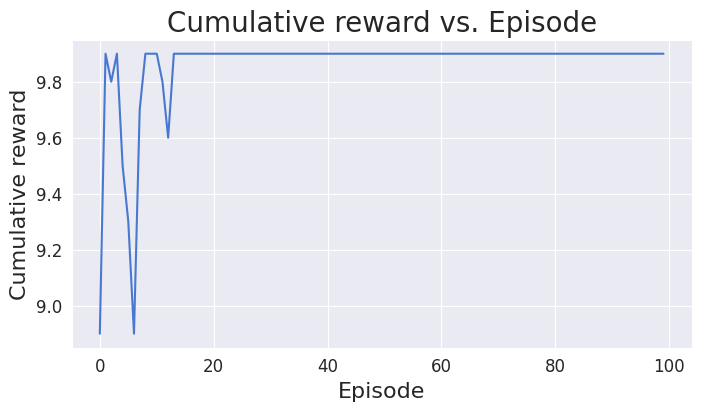

In [10]:
Q_n_step_sarsa_agent, rewards_n_step_sarsa_agent = n_step_sarsa_agent.run()

COMPARISION OF SARSA AND N-STEP SARSA

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


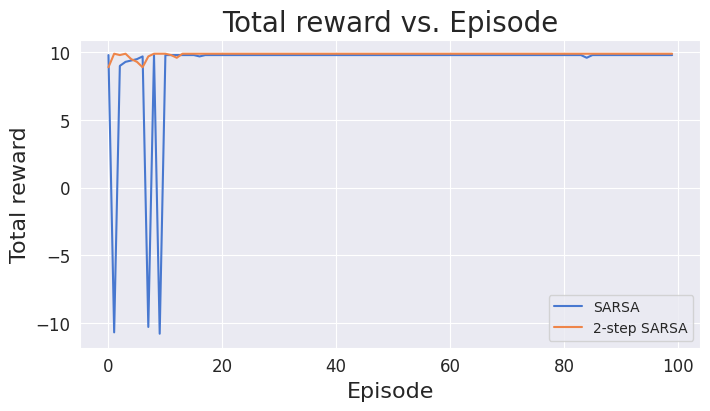

In [11]:
# Plotting the results
sns.set_style('darkgrid')
sns.set_palette('muted')
plt.figure(figsize=(8, 4))
sns.lineplot(x=range(len(rewards_sarsa)), y = rewards_sarsa, label = 'SARSA')
sns.lineplot(x=range(len(rewards_n_step_sarsa_agent)), y = rewards_n_step_sarsa_agent, label = '2-step SARSA')
plt.title('Total reward vs. Episode', fontsize=20)
plt.xlabel('Episode', fontsize=16)
plt.ylabel('Total reward', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend()
plt.show()

From the above graph, we can understand that the orange line which represents '2-step SARSA' model has performed better than 'SARSA' model, the graph of '2-step SARSA' is not fluctuating unlike 'SARSA', the rewards of '2-step SARSA' are not going below 5 from the starting.